In [1]:
from transformers import pipeline, AutoTokenizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer, util
import torch
import evaluate
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import textwrap
from summarization import sliding_window_summarization

os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
# Replace 'file_path.pkl' with the path to your .pkl file
df = pd.read_pickle("../results_2024_11_09_112019/articles.pkl")

In [3]:
# convert dictionary to dataframe
df = pd.DataFrame(df)
df.head(3)

,PMC11315657,PMC11204383,PMC11301388,PMC11240861,PMC11289611,PMC11286288,PMC11315276,PMC11312292,PMC11308427,PMC11303826,...,PMC11180946,PMC11097100,PMC11096445,PMC11284501,PMC10749615,PMC11152865,PMC11293442,PMC11152559,PMC10749592,PMC11213448
TITLE,[Exploring the association between melatonin a...,[Antibodies Against ZSCAN1 in Pediatric and Ad...,[Gingival mesenchymal stem cells: Biological p...,[Research progress of DNA methylation in color...,[Investigating the Relationship of Serum CD163...,[Genetic Associations With an Amyotrophic Late...,[The aperiodic exponent of neural activity var...,[mTOR activation induces endolysosomal remodel...,[Mendelian randomization study on causal assoc...,[Pooling Alzheimer's disease clinical trial da...,...,[The 2022 symposium on dementia and brain agin...,[Hyperbaric oxygen therapy: future prospects i...,[Dangers of the chronic stress response in the...,[Cortical similarities in psychiatric and mood...,[The autophagy protein Atg9 functions in glia ...,[Role of erythropoietin in the treatment of Al...,[CNTN4 modulates neural elongation through int...,[Evaluating protein prenylation of human and v...,[Mitophagy in neurodegenerative disease pathog...,[“The burden of lifestyle diseases and their i...
ABSTRACT,[Due to the addictive qualities of tobacco pro...,"[Objectives, To report the association of zinc...",[Our understanding of mesenchymal stem cells (...,[DNA methylation is one of the earliest and mo...,"[Objective, This study aimed to compare serum ...","[Background and Objectives, The term “ALS Reve...",[Recently the 1/f signal of human electroencep...,[Astrocytes respond and contribute to neuroinf...,"[Background, Previous research has revealed th...","[Abstract, With the advent of the first genera...",...,"[Abstract, Two of every three persons living w...",[Hyperbaric Oxygen Therapy (HBOT) utilizes 100...,[More than 20% of American adults live with a ...,"[Summary, Structural neuroimaging studies have...",[Parkinson’s disease is a progressive neurodeg...,[This review aims to explore the potential of ...,[The neuronal cell adhesion molecule contactin...,"[ABSTRACT, Prenylated proteins are prevalent i...",[Mitochondria are critical cellular energy res...,"[ABSTRACT, Basically, non-communicable disease..."
INTRO,"[Introduction, Nicotine dependence, a pervasiv...","[Introduction, Rapid-onset obesity with hypoth...","[Introduction, Mesenchymal stem cells, In the ...","[Introduction, Colorectal cancer (CRC) is one ...","[INTRODUCTION, Autism spectrum disorder (ASD) ...","[Introduction, Amyotrophic lateral sclerosis (...","[Introduction, Pink noise or 1/f signals is a ...","[Introduction, Astrocytes maintain homeostasis...","[Introduction, Pulmonary arterial hypertension...","[INTRODUCTION, Alzheimer's disease is the most...",...,"[INTRODUCTION, Approximately 50 million people...","[Introduction, Hyperbaric oxygen therapy (HBOT...","[Introduction, Over 1 in 5 youth and adults li...","[Introduction, Mental illness can be severe, c...","[Introduction, Parkinson’s disease (PD) is a n...","[Introduction, Highlights, Oxidative stress da...","[Introduction, Neurodevelopmental disorders su...","[INTRODUCTION, Post-translational modification...","[Introduction, Neurons are the basic structura...","[Introduction and Background, Lifestyle diseas..."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8 entries, TITLE to CONCL
Columns: 500 entries, PMC11315657 to PMC11213448
dtypes: object(500)
memory usage: 31.3+ KB


In [5]:
# transpose the dataframe and add an index column
df = df.T.reset_index()
df.head()

,index,TITLE,ABSTRACT,INTRO,CASE,METHODS,RESULTS,DISCUSS,CONCL
0,PMC11315657,[Exploring the association between melatonin a...,[Due to the addictive qualities of tobacco pro...,"[Introduction, Nicotine dependence, a pervasiv...",[],[Considering individual differences in treatme...,[],[],"[Future research directions and conclusions, F..."
1,PMC11204383,[Antibodies Against ZSCAN1 in Pediatric and Ad...,"[Objectives, To report the association of zinc...","[Introduction, Rapid-onset obesity with hypoth...",[],"[Methods, Patients and Samples, Thirteen patie...","[Results, ZSCAN1-abs were identified in 5 of 6...","[Discussion, The discovery of ZSCAN1-abs as a ...",[]
2,PMC11301388,[Gingival mesenchymal stem cells: Biological p...,[Our understanding of mesenchymal stem cells (...,"[Introduction, Mesenchymal stem cells, In the ...",[],"[Source, isolation, culture method, and prelim...",[],"[Limitations on GMSC practical use, Despite th...","[Conclusion, Over the last two decades, intere..."
3,PMC11240861,[Research progress of DNA methylation in color...,[DNA methylation is one of the earliest and mo...,"[Introduction, Colorectal cancer (CRC) is one ...",[],"[Availability of data and materials, Not appli...",[],[],"[Conclusions and outlook, The research prospec..."
4,PMC11289611,[Investigating the Relationship of Serum CD163...,"[Objective, This study aimed to compare serum ...","[INTRODUCTION, Autism spectrum disorder (ASD) ...",[],"[METHODS, Sample of the Study, Forty children ...","[RESULTS, Table 1 presents the data regarding ...","[DISCUSSION, In this study, the serum CD163, Y...",[]


In [6]:
# change the first column name to 'article_id'
df = df.rename(columns={"index": "article_id"})
df.head(3)

,article_id,TITLE,ABSTRACT,INTRO,CASE,METHODS,RESULTS,DISCUSS,CONCL
0,PMC11315657,[Exploring the association between melatonin a...,[Due to the addictive qualities of tobacco pro...,"[Introduction, Nicotine dependence, a pervasiv...",[],[Considering individual differences in treatme...,[],[],"[Future research directions and conclusions, F..."
1,PMC11204383,[Antibodies Against ZSCAN1 in Pediatric and Ad...,"[Objectives, To report the association of zinc...","[Introduction, Rapid-onset obesity with hypoth...",[],"[Methods, Patients and Samples, Thirteen patie...","[Results, ZSCAN1-abs were identified in 5 of 6...","[Discussion, The discovery of ZSCAN1-abs as a ...",[]
2,PMC11301388,[Gingival mesenchymal stem cells: Biological p...,[Our understanding of mesenchymal stem cells (...,"[Introduction, Mesenchymal stem cells, In the ...",[],"[Source, isolation, culture method, and prelim...",[],"[Limitations on GMSC practical use, Despite th...","[Conclusion, Over the last two decades, intere..."


In [7]:
# Convert all lists in the DataFrame to strings
df = df.apply(
    lambda x: x.map(lambda y: ", ".join(map(str, y)) if isinstance(y, list) else y),
    axis=0,
)

df.head(3)

,article_id,TITLE,ABSTRACT,INTRO,CASE,METHODS,RESULTS,DISCUSS,CONCL
0,PMC11315657,Exploring the association between melatonin an...,Due to the addictive qualities of tobacco prod...,"Introduction, Nicotine dependence, a pervasive...",,Considering individual differences in treatmen...,,,"Future research directions and conclusions, Fu..."
1,PMC11204383,Antibodies Against ZSCAN1 in Pediatric and Adu...,"Objectives, To report the association of zinc ...","Introduction, Rapid-onset obesity with hypotha...",,"Methods, Patients and Samples, Thirteen patien...","Results, ZSCAN1-abs were identified in 5 of 6 ...","Discussion, The discovery of ZSCAN1-abs as a b...",
2,PMC11301388,Gingival mesenchymal stem cells: Biological pr...,Our understanding of mesenchymal stem cells (M...,"Introduction, Mesenchymal stem cells, In the e...",,"Source, isolation, culture method, and prelimi...",,"Limitations on GMSC practical use, Despite the...","Conclusion, Over the last two decades, interes..."


In [8]:
# Check for missing values after converting lists to strings
df.isnull().sum()

article_id    0
TITLE         0
ABSTRACT      0
INTRO         0
CASE          0
METHODS       0
RESULTS       0
DISCUSS       0
CONCL         0
dtype: int64

In [9]:
# Replace empty strings with NaN
df = df.replace("", float("NaN"))
df.head(3)

,article_id,TITLE,ABSTRACT,INTRO,CASE,METHODS,RESULTS,DISCUSS,CONCL
0,PMC11315657,Exploring the association between melatonin an...,Due to the addictive qualities of tobacco prod...,"Introduction, Nicotine dependence, a pervasive...",NaN,Considering individual differences in treatmen...,NaN,NaN,"Future research directions and conclusions, Fu..."
1,PMC11204383,Antibodies Against ZSCAN1 in Pediatric and Adu...,"Objectives, To report the association of zinc ...","Introduction, Rapid-onset obesity with hypotha...",NaN,"Methods, Patients and Samples, Thirteen patien...","Results, ZSCAN1-abs were identified in 5 of 6 ...","Discussion, The discovery of ZSCAN1-abs as a b...",NaN
2,PMC11301388,Gingival mesenchymal stem cells: Biological pr...,Our understanding of mesenchymal stem cells (M...,"Introduction, Mesenchymal stem cells, In the e...",NaN,"Source, isolation, culture method, and prelimi...",NaN,"Limitations on GMSC practical use, Despite the...","Conclusion, Over the last two decades, interes..."


In [10]:
# Check for missing values after replacing empty strings with NaN
df.isnull().sum()

article_id      0
TITLE           0
ABSTRACT        0
INTRO           3
CASE          496
METHODS       146
RESULTS       201
DISCUSS       137
CONCL         198
dtype: int64

In [11]:
# CASE column: 496 missing out of 500 (99.2% missing) — Droping the column
df = df.drop(columns=["CASE"])
df.head(3)

,article_id,TITLE,ABSTRACT,INTRO,METHODS,RESULTS,DISCUSS,CONCL
0,PMC11315657,Exploring the association between melatonin an...,Due to the addictive qualities of tobacco prod...,"Introduction, Nicotine dependence, a pervasive...",Considering individual differences in treatmen...,NaN,NaN,"Future research directions and conclusions, Fu..."
1,PMC11204383,Antibodies Against ZSCAN1 in Pediatric and Adu...,"Objectives, To report the association of zinc ...","Introduction, Rapid-onset obesity with hypotha...","Methods, Patients and Samples, Thirteen patien...","Results, ZSCAN1-abs were identified in 5 of 6 ...","Discussion, The discovery of ZSCAN1-abs as a b...",NaN
2,PMC11301388,Gingival mesenchymal stem cells: Biological pr...,Our understanding of mesenchymal stem cells (M...,"Introduction, Mesenchymal stem cells, In the e...","Source, isolation, culture method, and prelimi...",NaN,"Limitations on GMSC practical use, Despite the...","Conclusion, Over the last two decades, interes..."


In [12]:
# replace NaN values with empty strings
df = df.fillna("")
df.head(3)

,article_id,TITLE,ABSTRACT,INTRO,METHODS,RESULTS,DISCUSS,CONCL
0,PMC11315657,Exploring the association between melatonin an...,Due to the addictive qualities of tobacco prod...,"Introduction, Nicotine dependence, a pervasive...",Considering individual differences in treatmen...,,,"Future research directions and conclusions, Fu..."
1,PMC11204383,Antibodies Against ZSCAN1 in Pediatric and Adu...,"Objectives, To report the association of zinc ...","Introduction, Rapid-onset obesity with hypotha...","Methods, Patients and Samples, Thirteen patien...","Results, ZSCAN1-abs were identified in 5 of 6 ...","Discussion, The discovery of ZSCAN1-abs as a b...",
2,PMC11301388,Gingival mesenchymal stem cells: Biological pr...,Our understanding of mesenchymal stem cells (M...,"Introduction, Mesenchymal stem cells, In the e...","Source, isolation, culture method, and prelimi...",,"Limitations on GMSC practical use, Despite the...","Conclusion, Over the last two decades, interes..."


In [13]:
# save the dataframe to a .csv file
# df.to_csv(
#     "articles.csv", index=False
# )

In [14]:
# Method to recreate the articles minus the abstracts
def combine_columns(df):
    """
    Combines the text from multiple columns into a single column for natural language processing.

    Args:
      df: A pandas DataFrame with columns 'article_id', 'TITLE', 'INTRO', 'CASE', 'METHODS', 'RESULTS', 'DISCUSS', 'CONCL'.

    Returns:
      A pandas DataFrame with a new column 'full_text' containing the combined text.
    """

    df["full_text"] = df.apply(
        lambda row: " ".join(
            [
                str(row["TITLE"]),
                str(row["INTRO"]),
                str(row["METHODS"]),
                str(row["RESULTS"]),
                str(row["DISCUSS"]),
                str(row["CONCL"]),
            ]
        ),
        axis=1,
    )
    return df

In [15]:
df_articles = combine_columns(df)
df_articles.head(3)

,article_id,TITLE,ABSTRACT,INTRO,METHODS,RESULTS,DISCUSS,CONCL,full_text
0,PMC11315657,Exploring the association between melatonin an...,Due to the addictive qualities of tobacco prod...,"Introduction, Nicotine dependence, a pervasive...",Considering individual differences in treatmen...,,,"Future research directions and conclusions, Fu...",Exploring the association between melatonin an...
1,PMC11204383,Antibodies Against ZSCAN1 in Pediatric and Adu...,"Objectives, To report the association of zinc ...","Introduction, Rapid-onset obesity with hypotha...","Methods, Patients and Samples, Thirteen patien...","Results, ZSCAN1-abs were identified in 5 of 6 ...","Discussion, The discovery of ZSCAN1-abs as a b...",,Antibodies Against ZSCAN1 in Pediatric and Adu...
2,PMC11301388,Gingival mesenchymal stem cells: Biological pr...,Our understanding of mesenchymal stem cells (M...,"Introduction, Mesenchymal stem cells, In the e...","Source, isolation, culture method, and prelimi...",,"Limitations on GMSC practical use, Despite the...","Conclusion, Over the last two decades, interes...",Gingival mesenchymal stem cells: Biological pr...


In [16]:
# Strip whitespace from each cell in the DataFrame
df_articles = df_articles.apply(
    lambda x: x.map(lambda y: y.strip() if isinstance(y, str) else y), axis=0
)
df_articles.head(3)

,article_id,TITLE,ABSTRACT,INTRO,METHODS,RESULTS,DISCUSS,CONCL,full_text
0,PMC11315657,Exploring the association between melatonin an...,Due to the addictive qualities of tobacco prod...,"Introduction, Nicotine dependence, a pervasive...",Considering individual differences in treatmen...,,,"Future research directions and conclusions, Fu...",Exploring the association between melatonin an...
1,PMC11204383,Antibodies Against ZSCAN1 in Pediatric and Adu...,"Objectives, To report the association of zinc ...","Introduction, Rapid-onset obesity with hypotha...","Methods, Patients and Samples, Thirteen patien...","Results, ZSCAN1-abs were identified in 5 of 6 ...","Discussion, The discovery of ZSCAN1-abs as a b...",,Antibodies Against ZSCAN1 in Pediatric and Adu...
2,PMC11301388,Gingival mesenchymal stem cells: Biological pr...,Our understanding of mesenchymal stem cells (M...,"Introduction, Mesenchymal stem cells, In the e...","Source, isolation, culture method, and prelimi...",,"Limitations on GMSC practical use, Despite the...","Conclusion, Over the last two decades, interes...",Gingival mesenchymal stem cells: Biological pr...


In [17]:
wrapper = textwrap.TextWrapper(width=80, break_long_words=False, break_on_hyphens=False)

In [18]:
# Method to print the full text of a single article by article_id
def print_article(df, article_id):
    """
    Prints the full text of a single article in a readable format.

    Args:
      df: A pandas DataFrame with a 'full_text' column and an 'article_id' column.
      article_id: The ID of the article to print.
    """

    article = df[df["article_id"] == article_id]["full_text"].values[0]

    print(wrapper.fill(article))

In [19]:
# get a random article_id
article_id = df_articles.sample()["article_id"].values[0]
# print the full text of a random article_id
print_article(df_articles, article_id)

Broadening the Genetic Spectrum of Painful Small-Fiber Neuropathy through
Whole-Exome Study in Early-Onset Cases 1. Introduction, Small-Fiber Neuropathy
(SFN) arises from damage to small nerve fibers, specifically the Aδ and
demyelinated C fibers, which transmit sensory signals and regulate autonomic
functions. SFN is a common disorder with a prevalence of 131.5 per 100,000
inhabitants. It presents with diverse symptoms, including sensory issues and
autonomic dysfunction, with neuropathic pain (NP) being the prominent feature.
Diagnosing SFN poses a challenge due to the variable intensity and distribution
of symptoms, which predominantly affect the lower extremities and may extend to
the upper limbs. Routine clinical examinations often fail to detect
abnormalities, leading to potential underdiagnosis of SFN. Therefore, advanced
diagnostic techniques such as Intra-Epidermal Nerve Fiber Density (IENFD)
determination through skin biopsy and temperature threshold testing (TTT) are
used for

In [20]:
# print article abstract
def print_abstract(df, article_id):
    """
    Prints the abstract of a single article in a readable format.

    Args:
      df: A pandas DataFrame with an 'article_id' column and a 'ABSTRACT' column.
      article_id: The ID of the article to print.
    """

    abstract = df[df["article_id"] == article_id]["ABSTRACT"].values[0]

    print(wrapper.fill(abstract))


print_abstract(df, article_id)

Small-Fiber Neuropathy (SFN) is a disorder of the peripheral nervous system,
characterised by neuropathic pain; approximately 11% of cases are linked to
variants in Voltage-Gated Sodium Channels (VGSCs). This study aims to broaden
the genetic knowledge on painful SFN by applying Whole-Exome Sequencing (WES) in
Early-Onset (EO) cases. A total of 88 patients from Italy (n = 52) and the
Netherlands (n = 36), with a disease onset at age ≤ 45 years old and a Pain
Numerical Rating Score ≥ 4, were recruited. After variant filtering and
classification, WES analysis identified 142 potentially causative variants in 93
genes; 8 are Pathogenic, 15 are Likely Pathogenic, and 119 are Variants of
Uncertain Significance. Notably, an enrichment of variants in transient receptor
potential genes was observed, suggesting their role in pain modulation alongside
VGSCs. A pathway analysis performed by comparing EO cases with 40 Italian
healthy controls found enriched mutated genes in the “Nicotinic acetylcho

array([[<Axes: title={'center': 'full_text_length'}>,
        <Axes: title={'center': 'abstract_length'}>]], dtype=object)

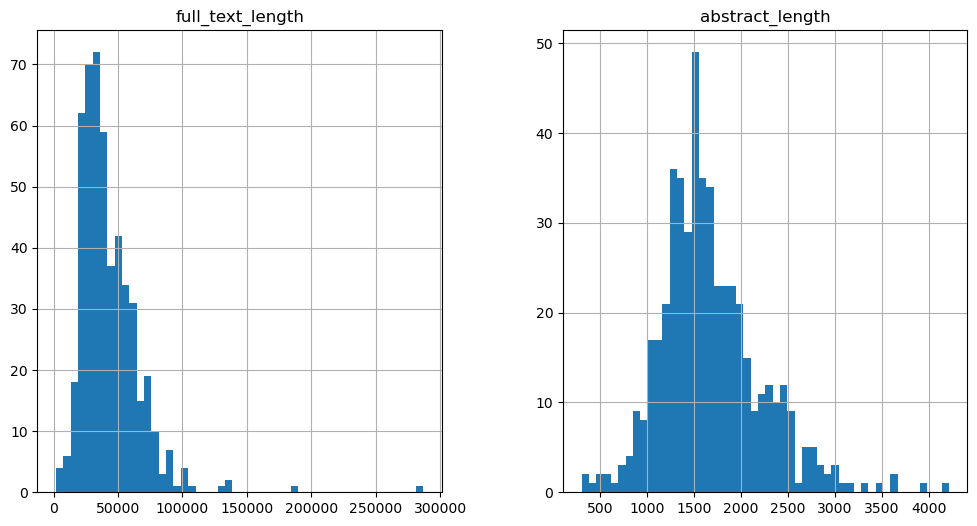

In [21]:
# create two lists 'full_text_length' and 'abstract_length' to store the length of each article and its abstract
full_text_length = []
abstract_length = []

# iterate through each row in the DataFrame
for index, row in df_articles.iterrows():
    # calculate the length of the 'full_text' and 'ABSTRACT' columns
    full_text_length.append(len(row["full_text"]))
    abstract_length.append(len(row["ABSTRACT"]))

data = pd.DataFrame([full_text_length, abstract_length]).T
data.columns = ["full_text_length", "abstract_length"]

data.hist(bins=50, figsize=(12, 6))

In [22]:
# Average length of full_text
data["full_text_length"].mean()
# Average length of abstract
data["abstract_length"].mean()

print("Average length of full_text:", data["full_text_length"].mean())
print("Average length of abstract:", data["abstract_length"].mean())

Average length of full_text: 42918.23
Average length of abstract: 1677.278


In [23]:
# Check for GPU support on Windows/Linux (CUDA) or MacOS (MPS)
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cuda


In [24]:
# Get a random index from the DataFrame
index = df_articles.sample().index[0]
# Get the full text of the article at the random index
article = df_articles.loc[index, "full_text"]
abstract = df_articles.loc[index, "ABSTRACT"]

In [25]:
print("Article:")
print(wrapper.fill(article))

Article:
Differential roles of lysosomal cholesterol transporters in the development of
C. elegans NMJs Introduction, The establishment of synaptic connections in the
nervous system is important for the efficient transmission of information and
the proper functioning of neural circuits. At synapses, presynaptic vesicle
fusion machinery and postsynaptic receptors are anchored by respective scaffold
proteins, which are physically linked to the intracellular cytoskeleton and the
trans-synaptic cell-adhesion molecules. Synapses can be organized through
trans-synaptic signaling pathways that are mediated by cell-adhesion molecules
such as neurexins and their ligands. Non-neuronal cells that are not part of
pre- or postsynaptic specialization can also contribute to synapse formation
through direct contact or the secretion of factors. One of these secreted
factors is cholesterol, which is an essential component of both presynaptic
vesicles and postsynaptic lipid rafts and plays crucial roles 

In [26]:
print("Abstract:")
print(wrapper.fill(abstract))

Abstract:
Neuronal cholesterol homeostasis during synapse development is controlled by two
NPC1 homologs in C. elegans: NCR-1 absorbs cholesterol and promotes
synaptogenesis, whereas NCR-2 uses cholesterol and hinders synaptogenesis.,
Cholesterol homeostasis in neurons is critical for synapse formation and
maintenance. Neurons with impaired cholesterol uptake undergo progressive
synapse loss and eventual degeneration. To investigate the molecular mechanisms
of neuronal cholesterol homeostasis and its role during synapse development, we
studied motor neurons of Caenorhabditis elegans because these neurons rely on
dietary cholesterol. Combining lipidomic analysis, we discovered that NCR-1, a
lysosomal cholesterol transporter, promotes cholesterol absorption and synapse
development. Loss of ncr-1 causes smaller synapses, and low cholesterol
exacerbates the deficits. Moreover, NCR-1 deficiency hinders the increase in
synapses under high cholesterol. Unexpectedly, NCR-2, the NCR-1 homolog,


In [27]:
# find the number of tokens in the article
tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-cnn")
tokens = tokenizer(article, return_tensors="pt")
num_tokens = tokens.input_ids.shape[1]
print("Number of tokens in the article:", num_tokens)

Number of tokens in the article: 12312


In [28]:
# find the number of tokens in the abstract
tokens = tokenizer(abstract, return_tensors="pt")
num_tokens = tokens.input_ids.shape[1]
print("Number of tokens in the abstract:", num_tokens)

Number of tokens in the abstract: 311


In [29]:
def summarize_article_with_model(
    article: str,
    model_name: str = "t5-small",
    max_length: int = 512,
    overlap: int = 128,
    redundancy_threshold: float = 0.8,
    summary_length: int = 300,
) -> str:
    """
    Summarizes an article using a specified model and the sliding window summarization method.

    Args:
        article (str): The article to summarize.
        model_name (str): The model name to use for summarization (default is 't5-small').
        max_length (int): Maximum token length for each chunk (default is 512).
        overlap (int): The number of tokens to overlap between chunks (default is 128).
        redundancy_threshold (float): The cosine similarity threshold for redundancy reduction (default is 0.8).
        summary_length (int): The maximum length of the summary (default is 100 characters).

    Returns:
        str: The summarized article.
    """
    # Initialize tokenizer and pipeline for summarization
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    summarization_pipeline = pipeline("summarization", model=model_name)

    # Call the sliding window summarization function
    summary = sliding_window_summarization(
        text=article,
        tokenizer=tokenizer,
        pipe=summarization_pipeline,
        max_length=max_length,
        overlap=overlap,
        redundancy_threshold=redundancy_threshold,
        summary_length=summary_length,
    )

    return summary

In [30]:
# Summarize the article using the BART model
model_name = "facebook/bart-large-cnn"

# Iitialize the tokenizer and pipeline for summarization
tokenizer = AutoTokenizer.from_pretrained(model_name)
summarization_pipeline = pipeline("summarization", model=model_name, device=device)

# Call the sliding window summarization function
summary = sliding_window_summarization(
    text=article,
    tokenizer=tokenizer,
    pipe=summarization_pipeline,
    max_length=512,
    overlap=128,
    redundancy_threshold=0.8,
    summary_length=900,
)

print("Summary:")
print(wrapper.fill(summary))

c:\Users\stanl\OneDrive\Documents\codes\research_summarizer\research_summarizer\summarization.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(previous_summary_embedding).clone().detach()


Skipping redundant summary (similarity 0.831)


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Skipping redundant summary (similarity 0.833)
Skipping redundant summary (similarity 0.859)
Skipping redundant summary (similarity 0.801)
Skipping redundant summary (similarity 0.914)
Skipping redundant summary (similarity 0.963)
Skipping redundant summary (similarity 0.917)


Your max_length is set to 142, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Summary:
Cholesterol is an essential component of both presynaptic vesicles and
postsynaptic lipid rafts and plays crucial roles in neurotransmission and
synaptic signaling. Astrocytes secrete apolipoprotein E (ApoE) particles
containing cholesterol, which are subsequently taken up by neurons via receptors
belonging to the low-density lipoprotein receptor family. Disturbances in the
cholesterol synthesis and secretion in astrocytes have been associated with
synaptic deficits and neurodegenerative disorders. Neurons rely on de novo
cholesterol biosynthesis for their survival and growth during early development.
Inactivation of cholesterol synthesis in postnatal neurons is required for
studying the regulation of cholesterol homeostasis during synapse development.


In [31]:
# Evaluate the BART model on the first article
rouge = evaluate.load("rouge")
bart_scores = rouge.compute(predictions=[summary], references=[df["ABSTRACT"][0]])
print(bart_scores)

{'rouge1': 0.17054263565891473, 'rouge2': 0.020779220779220776, 'rougeL': 0.11369509043927647, 'rougeLsum': 0.11369509043927647}


In [32]:
# Summarize an article using the Falconsai/medical_summarization
model_name = "Falconsai/medical_summarization"

# Initialize the tokenizer and pipeline for summarization
tokenizer = AutoTokenizer.from_pretrained(model_name)
summarization_pipeline = pipeline("summarization", model=model_name, device=device)

# Call the sliding window summarization function
summary = sliding_window_summarization(
    text=article,
    tokenizer=tokenizer,
    pipe=summarization_pipeline,
    max_length=512,
    overlap=128,
    redundancy_threshold=0.8,
    summary_length=900,
)

print("Summary:")
print(wrapper.fill(summary))

Token indices sequence length is longer than the specified maximum sequence length for this model (14178 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (514 > 512). Running this sequence through the model will result in indexing errors


Skipping redundant summary (similarity 0.945)
Skipping redundant summary (similarity 0.805)
Skipping redundant summary (similarity 0.893)
Skipping redundant summary (similarity 0.802)
Skipping redundant summary (similarity 0.841)
Skipping redundant summary (similarity 0.840)
Skipping redundant summary (similarity 0.848)
Skipping redundant summary (similarity 0.852)
Skipping redundant summary (similarity 0.843)
Skipping redundant summary (similarity 0.806)


Your max_length is set to 200, but your input_length is only 102. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)


Skipping redundant summary (similarity 0.908)
Summary:
apolipoprotein E (ApoE) particles containing cholesterol are subsequently taken
up by neurons via receptors belonging to the low-density lipoprotein receptor
family . despite the importance of intercellular crosstalk, our knowledge about
the intracellular mechanisms controlling cholesterol homeostasis in neurons and
its role in synapse development remains limited . granule cells deficient in
cholesterol biosynthesis develop normal synapses with Purkinje cells ,
hippocampal neurons deficient with a minimal presence of glial cells . neuronal
cholesterol homeostasis is a critical factor in synapse maintenance . however,
the causal link between impaired cholesterol synthesis and synaptic deficits has
yet to be established . the use of C.


In [33]:
# Evaluate the Falconsai/medical_summarization model on the first article
falconsai_scores = rouge.compute(predictions=[summary], references=[df["ABSTRACT"][0]])
print(falconsai_scores)

{'rouge1': 0.15503875968992248, 'rouge2': 0.010389610389610388, 'rougeL': 0.09819121447028423, 'rougeLsum': 0.09819121447028423}


In [34]:
# Summarize an article using the "google/bigbird-pegasus-large-pubmed" model
model_name = "google/bigbird-pegasus-large-pubmed"

# Initialize the tokenizer and pipeline for summarization
tokenizer = AutoTokenizer.from_pretrained(model_name)
summarization_pipeline = pipeline("summarization", model=model_name, device=device)

# Call the sliding window summarization function
summary = sliding_window_summarization(
    text=article,
    tokenizer=tokenizer,
    pipe=summarization_pipeline,
    max_length=3968,
    overlap=128,
    redundancy_threshold=0.8,
    summary_length=900,
)

print("Summary:")
print(wrapper.fill(summary))

Token indices sequence length is longer than the specified maximum sequence length for this model (10993 > 4096). Running this sequence through the model will result in indexing errors
Input ids are automatically padded from 3931 to 3968 to be a multiple of `config.block_size`: 64
Input ids are automatically padded from 3565 to 3584 to be a multiple of `config.block_size`: 64


Summary:
neurotransmission in the central nervous system ( cns ) is critical for learning
, memory , and spatial integration .<n> cholesterol is an important signaling
molecule involved in cns development and homeostasis .<n> however , the
molecular mechanisms by which cholesterol regulates the formation and function
of synapses are not well understood . in this study , we investigated the
involvement of cholesterol in the formation of synaptic vesicles in the ca3
region of the nematode caenorhabditis elegans .<n> first , we showed that the
formation of synaptic vesicles is significantly influenced by the amount of
extracellular cholesterol .<n> second , we demonstrated that cholesterol
inhibits the formation of synaptic vesicles .<n> third , we showed that the
cholesterol - binding protein , slc22a1 , is a regulator of the formation of
synaptic vesicles .


In [35]:
# Evaluate the "google/bigbird-pegasus-large-pubmed" model on the first article
bigbird_scores = rouge.compute(predictions=[summary], references=[df["ABSTRACT"][0]])
print(bigbird_scores)

{'rouge1': 0.1907090464547677, 'rouge2': 0.019656019656019656, 'rougeL': 0.117359413202934, 'rougeLsum': 0.117359413202934}


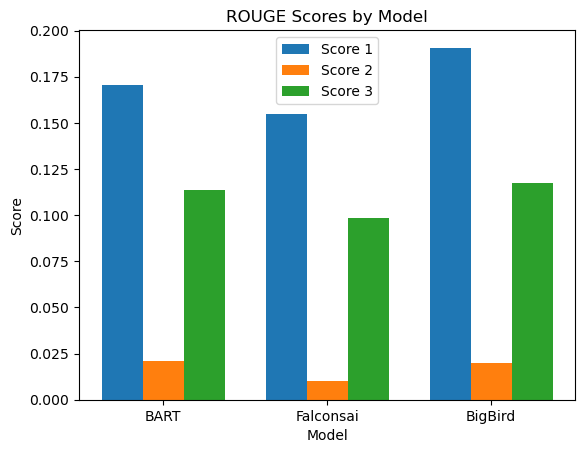

In [36]:
# Create a chart to compare the scores

models = ["BART", "Falconsai", "BigBird"]
scores_1 = [bart_scores["rouge1"], falconsai_scores["rouge1"], bigbird_scores["rouge1"]]
scores_2 = [bart_scores["rouge2"], falconsai_scores["rouge2"], bigbird_scores["rouge2"]]
scores_l = [bart_scores["rougeL"], falconsai_scores["rougeL"], bigbird_scores["rougeL"]]
scores = [scores_1, scores_2, scores_l]

fig, ax = plt.subplots()
bar_width = 0.25
index = range(len(models))

for i, score in enumerate(scores):
    ax.bar([x + bar_width * i for x in index], score, bar_width, label=f"Score {i + 1}")

ax.set_xlabel("Model")
ax.set_ylabel("Score")
ax.set_title("ROUGE Scores by Model")
ax.set_xticks([x + bar_width for x in index])
ax.set_xticklabels(models)
ax.legend()

plt.show()

In [37]:
# extract the article_id, abstract, and full_text columns into a new DataFrame
df_nlp = df_articles[["article_id", "full_text", "ABSTRACT"]]
df_nlp.head()

,article_id,full_text,ABSTRACT
0,PMC11315657,Exploring the association between melatonin an...,Due to the addictive qualities of tobacco prod...
1,PMC11204383,Antibodies Against ZSCAN1 in Pediatric and Adu...,"Objectives, To report the association of zinc ..."
2,PMC11301388,Gingival mesenchymal stem cells: Biological pr...,Our understanding of mesenchymal stem cells (M...
3,PMC11240861,Research progress of DNA methylation in colore...,DNA methylation is one of the earliest and mos...
4,PMC11289611,"Investigating the Relationship of Serum CD163,...","Objective, This study aimed to compare serum l..."


In [38]:
# save the dataframe to a .csv file
df_nlp.to_csv("articles.csv", index=False)

In [41]:
from datasets import Dataset, DatasetDict

# Split into training and test datasets
train_df, test_df = train_test_split(df_nlp, test_size=0.2, random_state=42)

# Convert to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Combine the training and test datasets
dataset = DatasetDict({"train": train_dataset, "test": test_dataset})

# Print the dataset
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['article_id', 'full_text', 'ABSTRACT', '__index_level_0__'],
        num_rows: 400
    })
    test: Dataset({
        features: ['article_id', 'full_text', 'ABSTRACT', '__index_level_0__'],
        num_rows: 100
    })
})


## To do: Fine-tuning LLM for our use case


In [42]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, TrainingArguments, Trainer

In [43]:
model_name = "Falconsai/medical_summarization"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

In [44]:
def tokenize(batch: dict, max_length: int = 1024, padding: str = "max_length", return_tensors: str = "pt"):
    """
    Tokenizes the input and target text from the batch using the specified tokenizer.

    Args:
        batch (dict): A dictionary containing the input and target text with keys "full_text" and "ABSTRACT".
        max_length (int, optional): The maximum length of the tokenized sequences. Defaults to 1024.
        padding (str, optional): Padding strategy. Defaults to "max_length".
        return_tensors (str, optional): The type of tensors to return. Defaults to "pt".

    Returns:
        dict: The tokenized and encoded representations of the input and target texts.
    """
    try:
        encoding = tokenizer(
            batch["full_text"],
            text_target=batch["ABSTRACT"],
            max_length=max_length,
            truncation=True,
            padding=padding,
            return_tensors=return_tensors,
        )
        return encoding
    except KeyError as e:
        raise ValueError(f"Missing key in batch: {e}")

In [46]:
# Tokenize the dataset with a maximum 512 tokens to prevent memory issues on GPU for initial testing
article_pt = dataset.map(lambda batch: tokenize(batch, max_length=512), batched=True, batch_size=None)

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [47]:
article_pt

DatasetDict({
    train: Dataset({
        features: ['article_id', 'full_text', 'ABSTRACT', '__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 400
    })
    test: Dataset({
        features: ['article_id', 'full_text', 'ABSTRACT', '__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 100
    })
})

In [48]:
# Create a data collator that will handle the preprocessing of the input data for the Seq2Seq model
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

# Define the training arguments, including the output directory, number of epochs, batch sizes, and other hyperparameters
args = TrainingArguments(
    output_dir="train_dir",  # Directory to save the model checkpoints and other artifacts
    num_train_epochs=2,  # Number of training epochs
    per_device_train_batch_size=4,  # Batch size for training
    per_device_eval_batch_size=4,  # Batch size for evaluation
    eval_strategy='epoch',  # Evaluate the model after each epoch
    save_strategy='epoch',  # Save the model checkpoints after each epoch
    weight_decay=0.01,  # L2 regularization strength
    learning_rate=2e-5,  # Learning rate for the optimizer
    gradient_accumulation_steps=500  # Number of gradient accumulation steps
)

# Create a Trainer instance that will handle the training process
trainer = Trainer(
    model=model,  # The Seq2Seq model to be trained
    args=args,  # The training arguments
    tokenizer=tokenizer,  # The tokenizer used for the input data
    data_collator=data_collator,  # The data collator for preprocessing the input data
    train_dataset=article_pt['train'],  # The training dataset
    eval_dataset=article_pt['test']  # The evaluation dataset
)

# Start the training process
trainer.train()

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 9.62520694732666, 'eval_runtime': 0.96, 'eval_samples_per_second': 104.167, 'eval_steps_per_second': 26.042, 'epoch': 1.0}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 9.516758918762207, 'eval_runtime': 0.962, 'eval_samples_per_second': 103.95, 'eval_steps_per_second': 25.988, 'epoch': 2.0}
{'train_runtime': 25.553, 'train_samples_per_second': 31.307, 'train_steps_per_second': 0.078, 'train_loss': 1.8317159414291382, 'epoch': 2.0}


TrainOutput(global_step=2, training_loss=1.8317159414291382, metrics={'train_runtime': 25.553, 'train_samples_per_second': 31.307, 'train_steps_per_second': 0.078, 'total_flos': 108273441177600.0, 'train_loss': 1.8317159414291382, 'epoch': 2.0})

In [49]:
# Save the trained model
trainer.save_model("research_summarization_model")

In [50]:
# Predict the summary for a single article
index = 0
article = df_nlp.loc[index, "full_text"]
abstract = df_nlp.loc[index, "ABSTRACT"]

model_name = "research_summarization_model"
tokenizer = AutoTokenizer.from_pretrained(model_name)

summarization_pipeline = pipeline("summarization", model=model_name, tokenizer=tokenizer, device=device)

# Call the sliding window summarization function
summary = sliding_window_summarization(
    text=article,
    tokenizer=tokenizer,
    pipe=summarization_pipeline,
    max_length=512,
    overlap=128,
    redundancy_threshold=0.8,
    summary_length=900,
)

print("Summary:")
print(wrapper.fill(summary))

Token indices sequence length is longer than the specified maximum sequence length for this model (8766 > 512). Running this sequence through the model will result in indexing errors
c:\Users\stanl\OneDrive\Documents\codes\research_summarizer\research_summarizer\summarization.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(previous_summary_embedding).clone().detach()


Skipping redundant summary (similarity 0.803)
Skipping redundant summary (similarity 0.838)
Skipping redundant summary (similarity 0.898)
Skipping redundant summary (similarity 0.894)
Skipping redundant summary (similarity 0.871)
Skipping redundant summary (similarity 0.815)
Skipping redundant summary (similarity 0.850)
Skipping redundant summary (similarity 0.803)
Skipping redundant summary (similarity 0.916)


Your max_length is set to 200, but your input_length is only 65. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)


Summary:
nicotine dependence continues to exact a significant toll on public health
globally . despite intensive research being made into the mechanisms underlying
nicotine addiction and its associated health consequences, effective strategies
for its prevention and interruption remain elusive . in recent years, emerging
evidence has shed light on the potential interplay between nicotine dependence
and the neuroendocrine hormone, melatonin . the addictive nature of nicotine
stems from its ability to activate the brain's reward pathways, particularly the
mesolimbic dopaminergic system leading to feelings of pleasure and reinforcement
of addictive behavior . the suprachiasmatic nucleus (SCN) of the hypothalamus
responds to environmental light-dark cycles by tightly controlling melatonin
secretion .


In [51]:
# Evaluate the custom model on the first article
rouge = evaluate.load("rouge")
r_s_m_scores = rouge.compute(predictions=[summary], references=[abstract])
print(r_s_m_scores)

{'rouge1': 0.2690355329949239, 'rouge2': 0.07142857142857142, 'rougeL': 0.17258883248730963, 'rougeLsum': 0.17258883248730963}
